"""

@Author: Samarth BM

@Date: 2021-11-11

@Last Modified by: Samarth BM.

@Title : To create a dataframe from cpu log data.csv file using pyspark library, and perform different operations using spark sql and also do visualization for the result.

"""

In [ ]:
import findspark

In [ ]:
findspark.init('/home/samarth/spark/')

In [ ]:
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import *

In [ ]:
df = spark.read.csv("hdfs://localhost:9000/CpuLogCSVFiles/*.csv", header=True)

To select only required columns

In [83]:
df1 = df.select("user_name","DateTime","keyboard","mouse")
df1.show()

+--------------------+-------------------+--------+------+
|           user_name|           DateTime|keyboard| mouse|
+--------------------+-------------------+--------+------+
|  iamnzm@outlook.com|2019-09-19 08:40:02|     1.0|  32.0|
|  iamnzm@outlook.com|2019-09-19 08:45:02|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:50:01|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:55:01|    11.0| 900.0|
|  iamnzm@outlook.com|2019-09-19 09:00:01|     2.0|  25.0|
|  iamnzm@outlook.com|2019-09-19 09:05:01|    37.0| 336.0|
|deepshukla292@gma...|2019-09-19 09:05:01|     0.0|  55.0|
|  iamnzm@outlook.com|2019-09-19 09:10:01|     0.0| 136.0|
|deepshukla292@gma...|2019-09-19 09:10:01|     6.0|1112.0|
|  iamnzm@outlook.com|2019-09-19 09:15:02|     0.0|  84.0|
|deepshukla292@gma...|2019-09-19 09:15:02|     0.0| 357.0|
|markfernandes66@g...|2019-09-19 09:15:01|    20.0| 670.0|
|markfernandes66@g...|2019-09-19 09:10:01|    17.0|   0.0|
|markfernandes66@g...|2019-09-19 09:20:01|    29.0|1895.

To get the counts of user

In [84]:
df2 = df1.groupBy("user_name").count()
df2.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



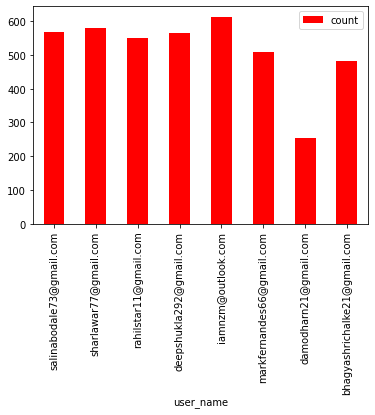

In [85]:
import matplotlib.pyplot as plt

try:
    pdf=df2.toPandas()
    pdf.plot.bar(x='user_name', y='count',color = 'r')
    plt.show()
except Exception as e:
    print(e)

In [86]:
df.createOrReplaceTempView("working_counts")

To count the users who are working

In [115]:
df3=spark.sql("SELECT user_name FROM working_counts WHERE keyboard!=0 or mouse!=0").groupBy("user_name").count()
df3.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  436|
|sharlawar77@gmail...|  457|
|rahilstar11@gmail...|  399|
|deepshukla292@gma...|  475|
|  iamnzm@outlook.com|  459|
|markfernandes66@g...|  389|
|damodharn21@gmail...|  191|
|bhagyashrichalke2...|  361|
+--------------------+-----+



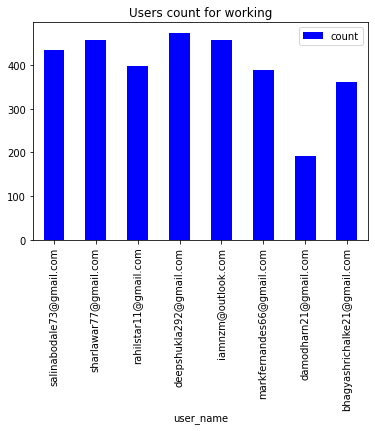

In [88]:
import matplotlib.pyplot as plt

try:
    pdf1=df3.toPandas()
    pdf1.plot.bar(x='user_name', y='count',color = 'b')
    plt.title("Users count for working")
    plt.show()
except Exception as e:
    print(e)

In [114]:
df3.createOrReplaceTempView("average_sec")

To get the average working seconds of users.

In [127]:
# df4=spark.sql("SELECT user_name,count,(((((count)*5)*60)/6)) as avg_sec FROM average_sec")
df4=spark.sql("SELECT user_name,from_unixtime(floor((((count)*5)*60)/6)) as avg_hour FROM average_sec")
df4.show()


+--------------------+-------------------+
|           user_name|           avg_hour|
+--------------------+-------------------+
|salinabodale73@gm...|1970-01-01 11:33:20|
|sharlawar77@gmail...|1970-01-01 11:50:50|
|rahilstar11@gmail...|1970-01-01 11:02:30|
|deepshukla292@gma...|1970-01-01 12:05:50|
|  iamnzm@outlook.com|1970-01-01 11:52:30|
|markfernandes66@g...|1970-01-01 10:54:10|
|damodharn21@gmail...|1970-01-01 08:09:10|
|bhagyashrichalke2...|1970-01-01 10:30:50|
+--------------------+-------------------+



To convert the average seconds to average hours.

In [113]:
from pyspark.sql.functions import *

highest_avg_hour = df4.withColumn("average_hours", concat(
            floor(col("avg_sec") % 86400 / 3600), lit(":"),
            floor((col("avg_sec") % 86400) % 3600 / 60), lit(""),
           
        )).drop("avg_sec")

  

In [91]:
highest_avg_hour.show()

+--------------------+-----+-------------+
|           user_name|count|average_hours|
+--------------------+-----+-------------+
|salinabodale73@gm...|  436|          6:3|
|sharlawar77@gmail...|  457|         6:20|
|rahilstar11@gmail...|  399|         5:32|
|deepshukla292@gma...|  475|         6:35|
|  iamnzm@outlook.com|  459|         6:22|
|markfernandes66@g...|  389|         5:24|
|damodharn21@gmail...|  191|         2:39|
|bhagyashrichalke2...|  361|          5:0|
+--------------------+-----+-------------+



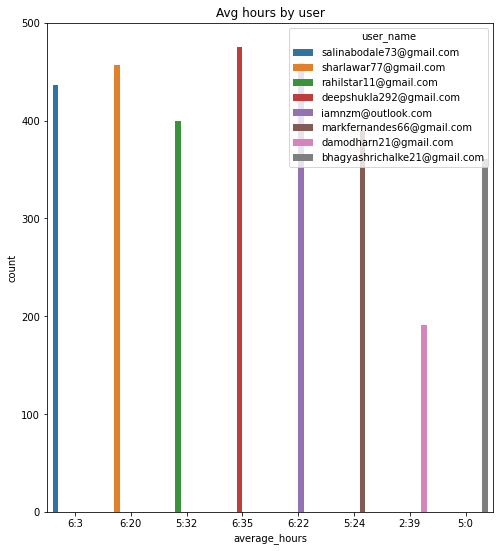

In [92]:

import seaborn as sns
from matplotlib import pyplot as plt

pdf3 = highest_avg_hour.toPandas()
plt.figure(figsize = (8,9))
sns.barplot(x = 'average_hours',y='count',data = pdf3,hue='user_name')
plt.title("Avg hours by user")
plt.ylim(0,500)
plt.show()

In [ ]:
highest_avg_hour.createOrReplaceTempView("working_hour")

To get the user with maximum and minimum working hours.

In [93]:
spark.sql("SELECT user_name as `user with highest avg hour`,average_hours  FROM working_hour WHERE average_hours = (SELECT MAX(average_hours) FROM working_hour)").show()

+--------------------------+-------------+
|user with highest avg hour|average_hours|
+--------------------------+-------------+
|      deepshukla292@gma...|         6:35|
+--------------------------+-------------+



In [94]:
spark.sql("SELECT user_name as `user with lowest avg hour`,average_hours FROM working_hour WHERE average_hours = (SELECT MIN(average_hours) FROM working_hour)").show()

+-------------------------+-------------+
|user with lowest avg hour|average_hours|
+-------------------------+-------------+
|     damodharn21@gmail...|         2:39|
+-------------------------+-------------+



To get the idle counts of user. 

In [95]:
df5=spark.sql("SELECT user_name FROM working_counts WHERE keyboard=0 and mouse=0").groupBy("user_name").count()
df5.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  133|
|sharlawar77@gmail...|  123|
|rahilstar11@gmail...|  152|
|deepshukla292@gma...|   90|
|  iamnzm@outlook.com|  155|
|markfernandes66@g...|  119|
|damodharn21@gmail...|   62|
|bhagyashrichalke2...|  121|
+--------------------+-----+



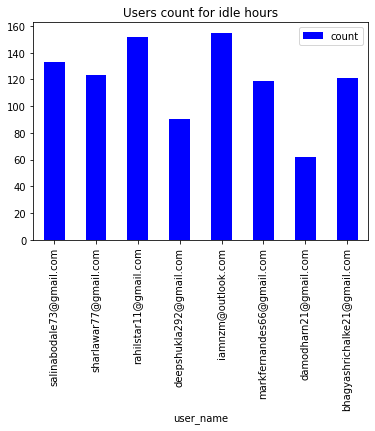

In [96]:
import matplotlib.pyplot as plt

try:
    pdf4=df5.toPandas()
    pdf4.plot.bar(x='user_name', y='count',color = 'b')
    plt.title("Users count for idle hours")
    plt.show()
except Exception as e:
    print(e)

In [97]:
df5.createOrReplaceTempView("idleHrs_by_user")

To get average idle seconds of user

In [98]:
idle_sec=spark.sql("SELECT user_name,count,(((((count)*5)*60)/6)) as avg_idle_seconds FROM idleHrs_by_user")
idle_sec.show()

+--------------------+-----+----------------+
|           user_name|count|avg_idle_seconds|
+--------------------+-----+----------------+
|salinabodale73@gm...|  133|          6650.0|
|sharlawar77@gmail...|  123|          6150.0|
|rahilstar11@gmail...|  152|          7600.0|
|deepshukla292@gma...|   90|          4500.0|
|  iamnzm@outlook.com|  155|          7750.0|
|markfernandes66@g...|  119|          5950.0|
|damodharn21@gmail...|   62|          3100.0|
|bhagyashrichalke2...|  121|          6050.0|
+--------------------+-----+----------------+



To convert idle seconds to idle hour

In [103]:
from pyspark.sql.functions import *

idle_hours = idle_sec.withColumn("Avg_idle_hours", concat(
            floor(col("avg_idle_seconds") % 86400 / 3600), lit(":"),
            floor((col("avg_idle_seconds") % 86400) % 3600 / 60), lit(""),
           
        )).drop("avg_idle_seconds")

In [104]:
idle_hours.show()

+--------------------+-----+--------------+
|           user_name|count|Avg_idle_hours|
+--------------------+-----+--------------+
|salinabodale73@gm...|  133|          1:50|
|sharlawar77@gmail...|  123|          1:42|
|rahilstar11@gmail...|  152|           2:6|
|deepshukla292@gma...|   90|          1:15|
|  iamnzm@outlook.com|  155|           2:9|
|markfernandes66@g...|  119|          1:39|
|damodharn21@gmail...|   62|          0:51|
|bhagyashrichalke2...|  121|          1:40|
+--------------------+-----+--------------+



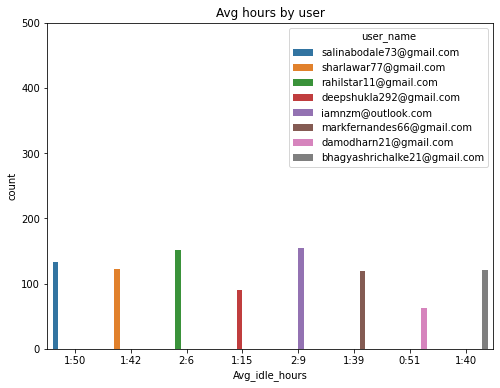

In [105]:
import seaborn as sns
from matplotlib import pyplot as plt

pdf5 = idle_hours.toPandas()
plt.figure(figsize = (8,6))
sns.barplot(x = 'Avg_idle_hours',y='count',data = pdf5,hue='user_name')
plt.title("Avg hours by user")
plt.ylim(0,500)
plt.show()

In [ ]:
idle_hours.createOrReplaceTempView("idle_hrs_view")

To get the user with highest and lowest idle hours

In [106]:
spark.sql("SELECT user_name as `user with highest idle hour`,Avg_idle_hours  FROM idle_hrs_view WHERE Avg_idle_hours = (SELECT MAX(Avg_idle_hours) FROM idle_hrs_view)").show()

+---------------------------+--------------+
|user with highest idle hour|Avg_idle_hours|
+---------------------------+--------------+
|         iamnzm@outlook.com|           2:9|
+---------------------------+--------------+



In [107]:
spark.sql("SELECT user_name as `user with lowest idle hour`,Avg_idle_hours  FROM idle_hrs_view WHERE Avg_idle_hours = (SELECT MIN(Avg_idle_hours) FROM idle_hrs_view)").show()

+--------------------------+--------------+
|user with lowest idle hour|Avg_idle_hours|
+--------------------------+--------------+
|      damodharn21@gmail...|          0:51|
+--------------------------+--------------+

